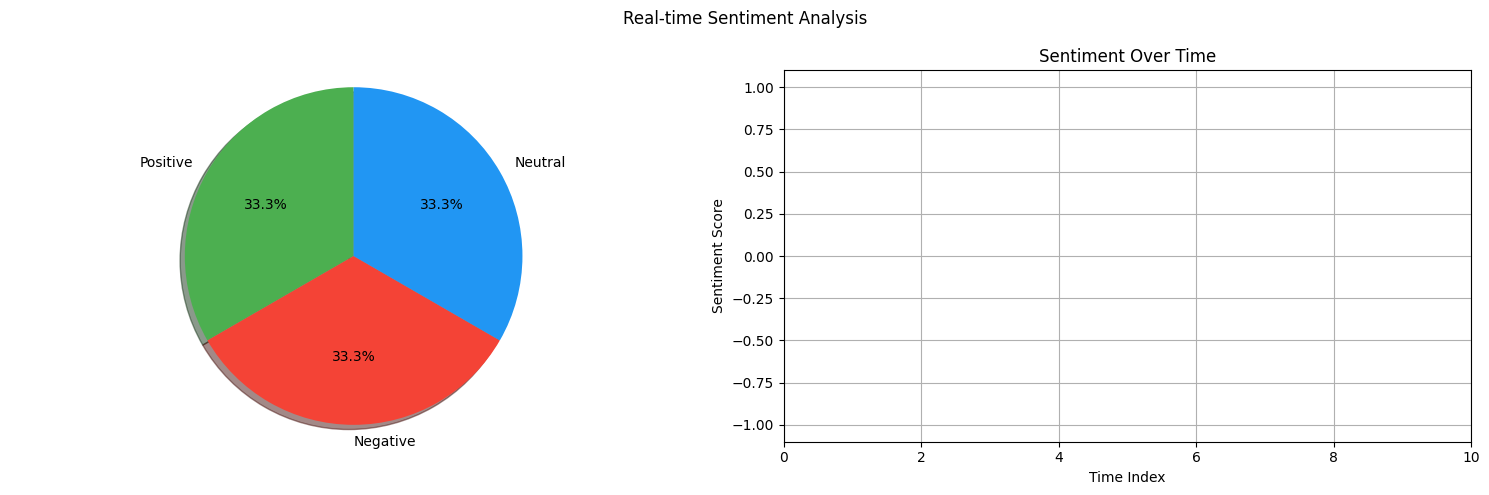

Stream started
Kafka-based sentiment analysis application started
Application running. Press Ctrl+C to stop.
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Processed 5 items
Stream stopped
Kafka-based sentiment analysis application stopped
Results saved to sentiment_results.json


Total messages analyzed: 150
Positive: 50 (33.3%)
Negative: 75 (50.0%)
Neutral: 25 (16.7%)


In [12]:
# Real-Time Sentiment Analysis System Using Big Data Technologies

# Installing required packages
!pip install pyspark findspark nltk textblob matplotlib plotly pandas numpy scikit-learn

# Importing libraries
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, DoubleType, IntegerType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from datetime import datetime
import io
import random
import threading
import json

# Downloading NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('sentiment/vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

class StreamSimulator:
    def __init__(self, data_source=None, batch_size=10, delay=1):
        self.batch_size = batch_size
        self.delay = delay
        self.is_running = False
        self.callback = None

        if data_source is None:
            self.data = self._generate_sample_data()
        elif isinstance(data_source, list):
            self.data = [item for item in data_source if isinstance(item, (str, dict))]
        elif isinstance(data_source, str):
            try:
                with open(data_source, 'r', encoding='utf-8') as f:
                    self.data = [line.strip() for line in f if line.strip()]
            except Exception as e:
                print(f"Error loading data: {e}")
                self.data = self._generate_sample_data()
        else:
            raise ValueError("Invalid data source type")

        random.shuffle(self.data)
        self.data_index = 0

    def _generate_sample_data(self):
        samples = [
            {"text": "This product is amazing! I absolutely love it.", "label": "positive"},
            {"text": "Terrible experience, would not recommend.", "label": "negative"},
            {"text": "It's okay, nothing special.", "label": "neutral"},
            {"text": "Excellent quality and fast delivery.", "label": "positive"},
            {"text": "Worst purchase ever, completely defective.", "label": "negative"},
            {"text": "Average product with average performance.", "label": "neutral"}
        ]
        return samples * 5

    def register_callback(self, callback):
        self.callback = callback

    def start(self):
        if self.is_running:
            print("Stream is already running")
            return

        self.is_running = True
        self.stream_thread = threading.Thread(target=self._stream_data)
        self.stream_thread.daemon = True
        self.stream_thread.start()
        print("Stream started")

    def stop(self):
        self.is_running = False
        print("Stream stopped")

    def _stream_data(self):
        while self.is_running:
            batch = []
            for _ in range(self.batch_size):
                if self.data_index >= len(self.data):
                    self.data_index = 0
                    random.shuffle(self.data)

                data_item = self.data[self.data_index].copy() if isinstance(self.data[self.data_index], dict) else {"text": self.data[self.data_index]}
                data_item["timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                batch.append(data_item)
                self.data_index += 1

            if self.callback:
                self.callback(batch)

            time.sleep(self.delay)

class SentimentAnalyzer:
    def __init__(self, method="vader"):
        self.method = method.lower()
        self.analyzer = SentimentIntensityAnalyzer() if method == "vader" else None

    def preprocess_text(self, text):
        if not isinstance(text, str):
            return ""
        text = text.lower().strip()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        return re.sub(r'\s+', ' ', text).strip()

    def analyze(self, text):
        if not isinstance(text, str) or len(text) < 3:
            return {"sentiment": "neutral", "compound": 0.0}

        processed_text = self.preprocess_text(text)
        try:
            if self.method == "vader":
                scores = self.analyzer.polarity_scores(processed_text)
                compound = scores['compound']
                sentiment = "neutral"
                if compound >= 0.05: sentiment = "positive"
                elif compound <= -0.05: sentiment = "negative"
                return {**scores, "sentiment": sentiment}
            elif self.method == "textblob":
                analysis = TextBlob(processed_text)
                polarity = analysis.sentiment.polarity
                sentiment = "neutral"
                if polarity > 0.1: sentiment = "positive"
                elif polarity < -0.1: sentiment = "negative"
                return {"polarity": polarity, "sentiment": sentiment}
        except Exception as e:
            print(f"Analysis error: {e}")
            return {"sentiment": "neutral", "error": str(e)}

class RealtimeVisualizer:
    def __init__(self):
        self.positive_count = 0
        self.negative_count = 0
        self.neutral_count = 0
        self.sentiment_history = []
        self.time_history = []

        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(15, 5))
        self.fig.suptitle('Real-time Sentiment Analysis')

        self.labels = ['Positive', 'Negative', 'Neutral']
        self.sizes = [1, 1, 1]
        self.colors = ['#4CAF50', '#F44336', '#2196F3']
        self.ax1.pie(self.sizes, labels=self.labels, colors=self.colors,
                    autopct='%1.1f%%', shadow=True, startangle=90)
        self.ax1.axis('equal')

        self.line, = self.ax2.plot([], [], 'b-')
        self.ax2.set_title('Sentiment Over Time')
        self.ax2.set_xlabel('Time Index')
        self.ax2.set_ylabel('Sentiment Score')
        self.ax2.set_ylim(-1.1, 1.1)
        self.ax2.set_xlim(0, 10)
        self.ax2.grid(True)

        plt.ion()
        plt.tight_layout()
        plt.show(block=False)

    def safe_update(self, sentiment_results):
        if not sentiment_results:
            return

        valid_scores = []
        for result in sentiment_results:
            if 'compound' in result:
                score = result['compound']
            elif 'polarity' in result:
                score = result['polarity']
            else:
                continue

            if not isinstance(score, (int, float)) or not np.isfinite(score):
                continue

            valid_scores.append(score)

            if result['sentiment'] == 'positive':
                self.positive_count += 1
            elif result['sentiment'] == 'negative':
                self.negative_count += 1
            else:
                self.neutral_count += 1

        if not valid_scores:
            return

        self.sentiment_history.extend(valid_scores)
        self.time_history = list(range(len(self.sentiment_history)))

        total = max(self.positive_count + self.negative_count + self.neutral_count, 1)
        sizes = [
            self.positive_count/total,
            self.negative_count/total,
            self.neutral_count/total
        ]

        self.ax1.clear()
        self.ax1.pie(
            [max(s, 0.001) for s in sizes],
            labels=self.labels,
            colors=self.colors,
            autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
            shadow=True,
            startangle=90
        )
        self.ax1.axis('equal')
        self.ax1.set_title(f'Sentiment Distribution (Total: {total})')

        if self.time_history:
            self.ax2.clear()
            self.ax2.plot(self.time_history, self.sentiment_history, 'b-')
            self.ax2.set_title('Sentiment Over Time')
            self.ax2.set_xlabel('Time Index')
            self.ax2.set_ylabel('Sentiment Score')
            self.ax2.set_ylim(-1.1, 1.1)
            self.ax2.set_xlim(0, max(10, len(self.time_history) + 5))
            self.ax2.grid(True)

        try:
            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
        except Exception as e:
            print(f"Visualization error: {e}")

class KafkaBasedSentimentAnalysisApp:
    def __init__(self, batch_size=10, delay=1, method="vader"):
        self.spark = SparkSession.builder \
            .appName("Real-time Sentiment Analysis") \
            .config("spark.driver.memory", "4g") \
            .getOrCreate()

        self.kafka_simulator = KafkaSimulator()
        self.topic_name = "streaming-text-data"
        self.kafka_simulator.create_topic(self.topic_name)

        self.producer = KafkaProducer(self.kafka_simulator, self.topic_name)
        self.consumer = KafkaConsumer(self.kafka_simulator, self.topic_name, batch_size)

        self.stream_simulator = StreamSimulator(batch_size=batch_size, delay=delay)
        self.sentiment_analyzer = SentimentAnalyzer(method)
        self.visualizer = RealtimeVisualizer()

        self.stream_simulator.register_callback(self.produce_to_kafka)
        self.spark_pipeline = SparkSentimentAnalysisPipeline(self.spark)

        self.all_results = []
        self.is_running = False
        self.consumer_thread = None

    def produce_to_kafka(self, batch):
        valid_messages = []
        for item in batch:
            if isinstance(item, dict) and 'text' in item:
                if isinstance(item['text'], str) and len(item['text'].strip()) > 0:
                    valid_messages.append(item)
            elif isinstance(item, str) and len(item.strip()) > 0:
                valid_messages.append({'text': item.strip()})

        for msg in valid_messages:
            self.producer.send(msg)

    def consume_from_kafka(self):
        while self.is_running:
            messages = self.consumer.poll()
            if not messages:
                time.sleep(0.1)
                continue

            valid_texts = []
            for item in messages:
                if isinstance(item, dict) and 'text' in item:
                    text = item['text']
                    if isinstance(text, str) and len(text.strip()) > 0:
                        valid_texts.append(text)

            if not valid_texts:
                continue

            results = []
            for text in valid_texts:
                try:
                    sentiment = self.sentiment_analyzer.analyze(text)
                    results.append({
                        'text': text,
                        'sentiment': sentiment.get('sentiment', 'neutral'),
                        **sentiment
                    })
                except Exception as e:
                    print(f"Analysis failed for text: {text[:50]}... Error: {e}")

            if results:
                self.visualizer.safe_update(results)
                self.all_results.extend(results)
                print(f"Processed {len(results)} items")

    def start(self):
        if self.is_running:
            print("Application is already running")
            return

        self.is_running = True
        self.consumer_thread = threading.Thread(target=self.consume_from_kafka)
        self.consumer_thread.daemon = True
        self.consumer_thread.start()
        self.stream_simulator.start()
        print("Kafka-based sentiment analysis application started")

    def stop(self):
        self.is_running = False
        self.stream_simulator.stop()

        if self.consumer_thread and self.consumer_thread.is_alive():
            self.consumer_thread.join(timeout=1)
        print("Kafka-based sentiment analysis application stopped")

    def save_results(self, filepath):
        with open(filepath, 'w') as f:
            json.dump(self.all_results, f)
        print(f"Results saved to {filepath}")

def visualize_results_plotly(results):
    if not results:
        print("No results to visualize")
        return

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Sentiment Distribution', 'Sentiment Over Time',
                       'Top Positive Words', 'Top Negative Words'),
        specs=[[{'type': 'pie'}, {'type': 'scatter'}],
               [{'type': 'bar'}, {'type': 'bar'}]]
    )

    sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}
    scores = []
    times = []
    texts = []

    for i, result in enumerate(results):
        sentiment_counts[result['sentiment']] += 1
        if 'compound' in result:
            score = result['compound']
        elif 'polarity' in result:
            score = result['polarity']
        else:
            score = 0
        scores.append(score)
        times.append(i)
        texts.append(result['text'])

    fig.add_trace(
        go.Pie(
            labels=list(sentiment_counts.keys()),
            values=list(sentiment_counts.values()),
            marker=dict(colors=['#4CAF50', '#F44336', '#2196F3']),
            name='Sentiment Distribution'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=scores,
            mode='lines+markers',
            name='Sentiment Score'
        ),
        row=1, col=2
    )

    positive_words = {}
    negative_words = {}
    for result in results:
        words = result['text'].lower().split()
        words = [word.strip('.,!?()[]{}:;"\'') for word in words]
        words = [word for word in words if word and len(word) > 2]

        if result['sentiment'] == 'positive':
            for word in words:
                positive_words[word] = positive_words.get(word, 0) + 1
        elif result['sentiment'] == 'negative':
            for word in words:
                negative_words[word] = negative_words.get(word, 0) + 1

    positive_words = sorted(positive_words.items(), key=lambda x: x[1], reverse=True)[:10]
    negative_words = sorted(negative_words.items(), key=lambda x: x[1], reverse=True)[:10]

    fig.add_trace(
        go.Bar(
            x=[word[0] for word in positive_words],
            y=[word[1] for word in positive_words],
            marker=dict(color='#4CAF50'),
            name='Top Positive Words'
        ),
        row=2, col=1
    )

    fig.add_trace(
        go.Bar(
            x=[word[0] for word in negative_words],
            y=[word[1] for word in negative_words],
            marker=dict(color='#F44336'),
            name='Top Negative Words'
        ),
        row=2, col=2
    )

    fig.update_layout(
        title_text='Sentiment Analysis Results',
        height=800,
        width=1200
    )

    fig.show()

    total = sum(sentiment_counts.values())
    print(f"Total messages analyzed: {total}")
    print(f"Positive: {sentiment_counts['positive']} ({sentiment_counts['positive']/total*100:.1f}%)")
    print(f"Negative: {sentiment_counts['negative']} ({sentiment_counts['negative']/total*100:.1f}%)")
    print(f"Neutral: {sentiment_counts['neutral']} ({sentiment_counts['neutral']/total*100:.1f}%)")

def run_application_with_visualization():
    app = KafkaBasedSentimentAnalysisApp(batch_size=5, delay=2, method="vader")
    app.start()

    try:
        print("Application running. Press Ctrl+C to stop.")
        time.sleep(60)
    except KeyboardInterrupt:
        pass

    app.stop()
    app.save_results("sentiment_results.json")

    if app.all_results:
        visualize_results_plotly(app.all_results)
    else:
        print("No results to visualize")

    return app

if __name__ == "__main__":
    try:
        nltk.data.find('vader_lexicon')
    except LookupError:
        nltk.download('vader_lexicon', quiet=True)

    app = run_application_with_visualization()
